In [ ]:
import numpy as np
import random 
from collections import defaultdict
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Defining bandits:

In [ ]:
def get_reward(idx, mu_sigma_dict):
	mu, sigma = mu_sigma_dict[idx]
	return np.random.normal(mu, sigma)

def generate_data(num_buttons):
	mu_sigma_dict = defaultdict(tuple)
	for i in range(num_buttons):
		mean = random.uniform(-1, 1)
		sigma = random.uniform(0, 3)
		mu_sigma_dict[i] = (mean, sigma)
	print("Distribution (unknown) : {} \n".format(mu_sigma_dict))
	return mu_sigma_dict

def get_optimum_reward(mu_sigma_dict, trials):
	mean_list = [value[0] for value in mu_sigma_dict.values()]
	max_mean_idx = np.argmax(mean_list)
	optimum_reward = np.sum([get_reward(max_mean_idx, mu_sigma_dict) for _ in range(trials)])

	return optimum_reward

In [ ]:
num_bandits = 5
mu_sigma_dict = generate_data(num_bandits)

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (-0.016494376858104953, 2.1137223116422823), 1: (0.33068608420433643, 1.0871434938953244), 2: (-0.9425080908098407, 2.5326806178044827), 3: (-0.5881594453891408, 2.1193319162394655), 4: (-0.5590335015733277, 2.392652887897602)}) 



Defining agent:

Training:

In [ ]:
# Launch the tensorflow graph

def policy_gradient(mu_sigma_dict, total_episodes = 1000, epsilon = 0.3):
  tf.reset_default_graph()

  num_bandits = len(mu_sigma_dict.keys())

  # Initial weights and action

  weights = tf.Variable(tf.ones([num_bandits]))
  # print("Initial weights", weights)

  chosen_action = tf.argmax(weights,0)
  # print("Action:", chosen_action)

  # reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
  advantage_holder = tf.placeholder(shape=[1],dtype=tf.float32)
  action_holder = tf.placeholder(shape=[1],dtype=tf.int32)
  # lr = tf.placeholder(shape=[1],dtype=tf.int32)
  lr = 0.001
  responsible_weight = tf.slice(weights,action_holder,[1])

  # Loss function and update
  loss = -(tf.log(responsible_weight)*advantage_holder)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
  update = optimizer.minimize(loss)
 
  total_reward = np.zeros(num_bandits) # Scoreboard for bandits set to 0.
  alpha = 0.001 

  init = tf.initialize_all_variables()

  with tf.Session() as sess:
      sess.run(init)
      i = 0
      while i < total_episodes:
          
          # Choose action using e-greedy
          if np.random.rand(1) < epsilon:
              action = np.random.randint(num_bandits)
          else:
              action = sess.run(chosen_action)
          
          reward = get_reward(action, mu_sigma_dict)
          total_reward[action] += reward
          avg_reward = np.mean(total_reward)
          advantage = reward - avg_reward

          #  Update the network.
          new_update, resp_weight, updated_weights = sess.run([update, responsible_weight, weights], feed_dict={advantage_holder:[advantage],action_holder:[action]})
          
          #Update our running tally of scores.
          # total_reward[action] += reward
          # if i % 50 == 0:
          #     print("Running reward for the " + str(num_bandits) + " bandits: " + str(total_reward))
          i+=1
  
  reward_sum = sum(total_reward)
  return reward_sum, updated_weights

In [ ]:
reward_sum, ww = policy_gradient(mu_sigma_dict, total_episodes = 1000)
print("The agent thinks bandit " + str(np.argmax(ww)) + " is the most promising....")
print("Final weights", ww)
print("Bandit Distribution: {} \n".format(mu_sigma_dict))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
The agent thinks bandit 0 is the most promising....
Final weights [3.5729775 1.3286947 1.250613  1.1536287 1.3234217]
Bandit Distribution: defaultdict(<class 'tuple'>, {0: (-0.016494376858104953, 2.1137223116422823), 1: (0.33068608420433643, 1.0871434938953244), 2: (-0.9425080908098407, 2.5326806178044827), 3: (-0.5881594453891408, 2.1193319162394655), 4: (-0.5590335015733277, 2.392652887897602)}) 



In [ ]:
def compute_regret(mu_sigma_dict, num_list, strategy = 'naive'):
    
    regret_avg = []
    
    for trials in num_list:
        regret = []
        for _ in range(5):
            if strategy == 'naive':
                reward, _, _ = naive_strategy(mu_sigma_dict, trials)
            elif strategy == 'probability':
                reward = probability_strategy(mu_sigma_dict, total_trials = trials)
            elif strategy == 'epsilon-greedy':
                reward = epsilon_greedy(mu_sigma_dict, trials)
            elif strategy == 'epsilon-greedy-time-variant':
                reward = epsilon_greedy(mu_sigma_dict, trials, epsilon_time_variant = True)
            elif strategy == 'ucb':
                reward = ucb(mu_sigma_dict, trials)
            elif strategy == 'ucb-unknown-variance':
                reward = ucb_unknown_variance(mu_sigma_dict, trials)
            elif strategy == 'policy_gradient':
                reward, weights = policy_gradient(mu_sigma_dict, trials)

            optimum_reward = get_optimum_reward(mu_sigma_dict, trials)
            regret.append(optimum_reward - reward)
        regret_avg.append(np.mean(regret))
#         print("Optimum reward = {}, reward = {}".format(optimum_reward, reward))
#     print("Regret = ", regret)

    return regret_avg 

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (0.46271102404439723, 0.30533091519041333), 1: (0.1560823276062555, 1.1565196447054964), 2: (0.5455128791030153, 0.23562042971590869), 3: (0.1795561441026241, 1.4441019041421101), 4: (0.5692514973792413, 0.28145933865747796), 5: (-0.5147113682343734, 2.9632972286263968), 6: (-0.9745394494148414, 1.0140961819102627), 7: (-0.7562220453946051, 0.09921656941295343)}) 



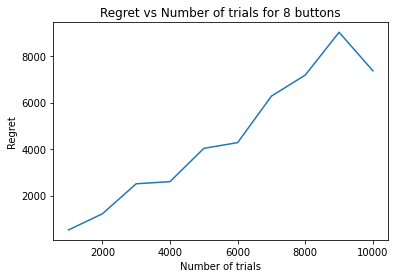

In [ ]:
# Plot for regret

num_buttons = 8
mu_sigma_dict = generate_data(num_buttons)
num_list = np.arange(1000, 10001, 1000)
regret = compute_regret(mu_sigma_dict, num_list, strategy = 'policy_gradient')
plt.plot(num_list, regret, '-')
plt.xlabel("Number of trials")
plt.ylabel("Regret")
plt.title("Regret vs Number of trials for {} buttons".format(num_buttons))
plt.show()